# Predicting Loan Defaults for Small Business Loans


## Building a model

In [28]:
#Import necessary Python packages 

#data analysis tools
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta


#plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz 

#classification 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor


In [2]:
#Load cleaned data
data = pd.read_pickle('loans_7a_matured')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650263 entries, 0 to 650262
Columns: 106 entries, TermInMonths to 2017
dtypes: float64(2), int64(4), object(1), uint8(99)
memory usage: 96.1+ MB


### Remove the year - to make the model useful for future years 

In [20]:
data.drop(list(data.columns)[80:], axis = 1, inplace = True)

### Target Variable:
Loan Status - Paid in full  



In [22]:
data['PIF'].value_counts()

1    492214
0    158049
Name: PIF, dtype: int64

In [23]:
#percent defaulted
100*(data['PIF']==0).sum() / len(data)

24.305396431905244

In [24]:
#split into training and testing 
#random split
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(data.drop(['GrossChargeOffAmountAdj', 'PIF'], axis = 1),
                                                               data['PIF'], test_size=0.30, random_state=101)


In [25]:
#Try logistic regression first 
logmodel_v1 = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
logmodel_v1.fit(X_train_v1, y_train_v1)
lm_v1_pred = logmodel_v1.predict(X_test_v1)

In [26]:
print(classification_report(y_test_v1, lm_v1_pred))

             precision    recall  f1-score   support

          0       0.50      0.75      0.60     47468
          1       0.90      0.76      0.82    147611

avg / total       0.80      0.75      0.77    195079



In [29]:
#GridSearch for Logistic Regression - vary the amount of regularization
param_grid = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]}
grid_logmodel = GridSearchCV(LogisticRegression(class_weight = 'balanced', n_jobs = -1), param_grid, refit=True,verbose=1)
grid_logmodel.fit(X_train_v1, y_train_v1)
print(grid_logmodel.best_params_)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  3.6min finished


{'C': 0.001}


In [32]:
grid_pred = grid_logmodel.predict(X_test_v1)

In [33]:
print(classification_report(y_test_v1, grid_pred))

             precision    recall  f1-score   support

          0       0.50      0.75      0.60     47468
          1       0.90      0.76      0.82    147611

avg / total       0.80      0.75      0.77    195079



Not much better than with the default C = 1!

In [34]:
#try simple decision tree with random split
#better accuracy can be achieved without the max_depth and min_samples_leaf constraints

dtree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 5, class_weight = 'balanced')
dtree.fit(X_train_v1, y_train_v1)
tree_pred = dtree.predict(X_test_v1)

print(classification_report(y_test_v1, tree_pred))


             precision    recall  f1-score   support

          0       0.57      0.94      0.71     47468
          1       0.98      0.77      0.86    147611

avg / total       0.88      0.81      0.83    195079



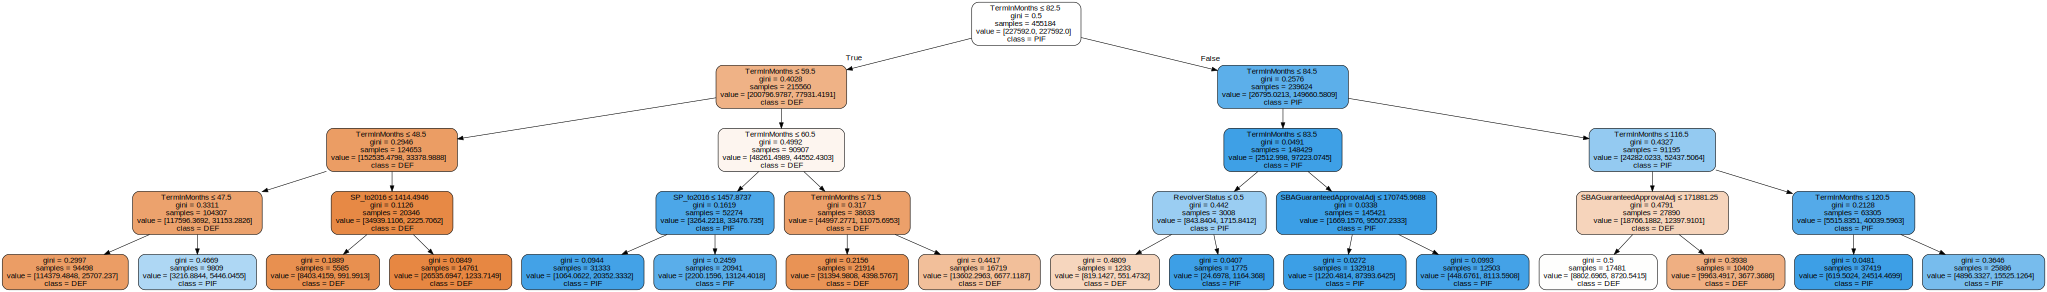

In [40]:
#visualize the tree
dot_data = tree.export_graphviz(dtree, out_file = None, 
                         feature_names = X_train_v1.columns,  
                         class_names = ['DEF', 'PIF'],  
                         filled = True, rounded = True,  
                         special_characters = True)  
graph = graphviz.Source(dot_data)  
graph.render("dec_tree_simple") 
graph

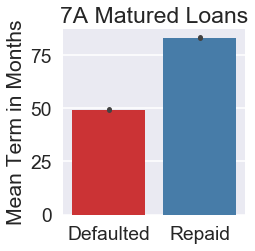

In [62]:
#Term in months seems the most important from the Decision Tree
fig = plt.figure(figsize = (5,3), facecolor = 'gainsboro')
sns.set_context('poster', font_scale = 1.2)


g = sns.factorplot(x = 'PIF', y = 'TermInMonths',
                   kind = 'bar', data = data, estimator = np.mean, palette = 'Set1' )

g.set_xticklabels(['Defaulted', 'Repaid'])
sns.plt.xlabel('')
sns.plt.title('7A Matured Loans')
sns.plt.ylabel('Mean Term in Months')
g.savefig('Term.png', dpi = 300)

### Paid in full loans have longer duration! 

In [49]:
#try random forest with random split
rf = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced', n_jobs=-1)
rf.fit(X_train_v1, y_train_v1)
rf_pred = rf.predict(X_test_v1)
print(classification_report(y_test_v1, rf_pred))

             precision    recall  f1-score   support

          0       0.83      0.77      0.80     47468
          1       0.93      0.95      0.94    147611

avg / total       0.90      0.91      0.91    195079



In [51]:
#try random forest with random split
rf_100 = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs=-1)
rf_100.fit(X_train_v1, y_train_v1)
rf_100_pred = rf_100.predict(X_test_v1)
print(classification_report(y_test_v1, rf_100_pred))

             precision    recall  f1-score   support

          0       0.83      0.78      0.80     47468
          1       0.93      0.95      0.94    147611

avg / total       0.91      0.91      0.91    195079



100 estimators achieves the same precision and recall as 300 estimators!

Feature ranking:
1. feature TermInMonths (0.539749)
2. feature SBAGuaranteedApprovalAdj (0.116471)
3. feature SP_to2016 (0.113057)
4. feature JobsSupported (0.054012)
5. feature RevolverStatus (0.013484)
6. feature INDIVIDUAL (0.007657)
7. feature CA (0.006051)
8. feature Retail Trade (0.005016)
9. feature Health Care & Social Assistance (0.004883)
10. feature FL (0.004826)
11. feature Other Services (0.004626)
12. feature Construction (0.004557)
13. feature FranchiseCodeBin (0.004298)
14. feature NY (0.004197)
15. feature Professional, Scientific, & Technical Services (0.004194)
16. feature TX (0.004108)
17. feature Manufacturing (0.003949)
18. feature Wholesale Trade (0.003841)
19. feature Administrative/Support/Waste Management (0.003315)
20. feature OH (0.003227)
21. feature PA (0.003155)
22. feature PARTNERSHIP (0.003000)
23. feature Transportation & Warehousing (0.002960)
24. feature NJ (0.002942)
25. feature GA (0.002686)
26. feature IL (0.002670)
27. feature MA (0.002631)
28. f

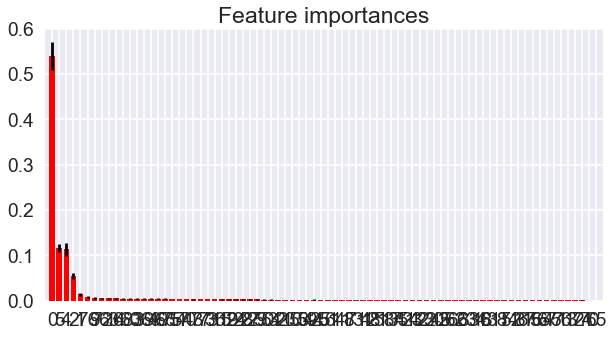

In [52]:
#feature ranking for random forest
fig = plt.figure(figsize = (10,5))
importances = rf_100.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_100.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]
fts = list(X_train_v1.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_v1.shape[1]):
   print("%d. feature %s (%f)" % (f + 1, fts[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.title("Feature importances")
plt.bar(range(X_train_v1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_v1.shape[1]), indices)

plt.xlim([-1, X_train_v1.shape[1]])
plt.show()


In [53]:
fig.savefig('RF_100est_FImportance.png', dpi = 300)

In [55]:
#GridSearch for RF
from sklearn.model_selection import GridSearchCV
param_grid = {'max_features': [0.2, 'auto', 'log2'],
              'n_estimators': [100], 'min_samples_leaf': [1, 5, 10, 50, 100, 500]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced', n_jobs = -1),
                param_grid, cv = 10, refit = True,verbose = 3, scoring = 'f1_score')


In [56]:
grid_rf.fit(X_train_v1, y_train_v1)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.947854, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.948405, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.948347, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.947620, total= 1.6min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.948230, total= 1.6min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.946140, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.946924, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=100, score=0.949187, total= 1.7min
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=100 ..........
[CV]  max_features=0.2

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 389.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [0.2, 'auto', 'log2'], 'n_estimators': [100], 'min_samples_leaf': [1, 5, 10, 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=3)

In [57]:
print(grid_rf.best_params_)
grid_rf_pred = grid_rf.predict(X_test_v1)

{'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100}


In [58]:
print(classification_report(y_test_v1, grid_rf_pred))

             precision    recall  f1-score   support

          0       0.82      0.74      0.78     47468
          1       0.92      0.95      0.93    147611

avg / total       0.90      0.90      0.90    195079



In [59]:
#Optimizing for f1 score gives max_features = 0.2
rf_opt = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, 
                                max_features = 0.2, class_weight = 'balanced', oob_score = True, n_jobs=-1)
rf_opt.fit(X_train_v1, y_train_v1)
rf_opt_pred = rf_opt.predict(X_test_v1)
print(classification_report(y_test_v1, rf_opt_pred))

             precision    recall  f1-score   support

          0       0.84      0.82      0.83     47468
          1       0.94      0.95      0.95    147611

avg / total       0.92      0.92      0.92    195079



In [63]:
#feature ranking for random forest
importances_rf_opt = rf_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_],
            axis=0)
indices_rf_opt = np.argsort(importances_rf_opt)[::-1]
fts_rf_opt = list(X_train_v1.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_v1.shape[1]):
   print("%d. feature %s (%f)" % (f + 1, fts_rf_opt[indices_rf_opt[f]], importances_rf_opt[indices_rf_opt[f]]))



Feature ranking:
1. feature TermInMonths (0.578101)
2. feature SBAGuaranteedApprovalAdj (0.101801)
3. feature SP_to2016 (0.097351)
4. feature JobsSupported (0.045797)
5. feature RevolverStatus (0.013711)
6. feature INDIVIDUAL (0.007462)
7. feature CA (0.006929)
8. feature Retail Trade (0.005802)
9. feature Construction (0.004943)
10. feature Other Services (0.004774)
11. feature FL (0.004745)
12. feature Manufacturing (0.004591)
13. feature Health Care & Social Assistance (0.004578)
14. feature TX (0.004565)
15. feature Professional, Scientific, & Technical Services (0.004482)
16. feature NY (0.004415)
17. feature Wholesale Trade (0.003989)
18. feature FranchiseCodeBin (0.003849)
19. feature PA (0.003484)
20. feature Administrative/Support/Waste Management (0.003299)
21. feature OH (0.003271)
22. feature NJ (0.002994)
23. feature Transportation & Warehousing (0.002928)
24. feature GA (0.002872)
25. feature IL (0.002806)
26. feature MN (0.002746)
27. feature PARTNERSHIP (0.002676)
28. f

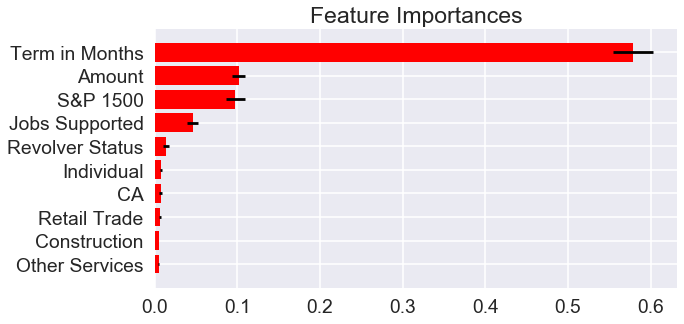

In [69]:
# Plot the feature importances of the forest
importances = rf_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
fig = plt.figure(figsize = (10,5))

plt.title("Feature Importances")
plt.barh(range(10), importances[indices][0:10][::-1],
       color="r", xerr=std[indices][0:10][::-1], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), ['Term in Months', 'Amount', 'S&P 1500', 'Jobs Supported', 'Revolver Status',
                      'Individual', 'CA', 'Retail Trade', 'Construction', 'Other Services'][::-1])
    
plt.yticks(range(10))
plt.ylim([-1,10])
plt.tight_layout()


fig.savefig('GRID_RF_FImportance.png', dpi = 300)

In [70]:
rf_opt.oob_score_

0.91571979682941407

In [74]:
#Examine loans with TermDuration = 84
data_84 = data[data['TermInMonths'] == 84]

In [77]:
data_84.reset_index(inplace=True, drop = True)

In [78]:
data_84.columns

Index(['TermInMonths', 'RevolverStatus', 'JobsSupported', 'FranchiseCodeBin',
       'SP_to2016', 'SBAGuaranteedApprovalAdj', 'GrossChargeOffAmountAdj',
       'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY', 'Administrative/Support/Waste Management',
       'Agriculture', 'Arts, Entertainment, & Recreation', 'Construction',
       'Educational Services', 'Finance & Insurance',
       'Health Care & Social Assistance', 'Information',
       'Management of Companies & Enterprises', 'Manufacturing', 'Mining',
       'Other Services', 'Professional, Scientific, & Technical Services',
       'Public Administration', 'Real Estate Rental & Leasing', 'Retail Trade',
       'Transportation & Warehousing', 'Utiliti

In [79]:
data_84.drop(['TermInMonths', 'GrossChargeOffAmountAdj'], axis = 1, inplace = True)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
#random split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_84.drop('PIF', axis = 1), 
                                                                data_84['PIF'], stratify = data_84['PIF'],
                                                                test_size = 0.30, random_state=101)


In [81]:
#try random forest with random split
rf_84 = RandomForestClassifier(max_features = 0.2, n_estimators = 100, n_jobs=-1, class_weight = "balanced")
rf_84.fit(X_train_v2, y_train_v2)
rf_84_pred = rf_84.predict(X_test_v2)

In [82]:
print(classification_report(y_test_v2, rf_84_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       347
          1       0.99      1.00      1.00     61985

avg / total       0.99      0.99      0.99     62332



In [83]:
data_84['PIF'].value_counts()

1    206616
0      1157
Name: PIF, dtype: int64

For loans of duration = 84 months, < 0.5% default!

In [95]:
#Examine only the business-relevant features
data_bo = data.iloc[:, np.r_[2, 3, 58:80]]


In [96]:
data_bo.columns

Index(['JobsSupported', 'FranchiseCodeBin',
       'Administrative/Support/Waste Management', 'Agriculture',
       'Arts, Entertainment, & Recreation', 'Construction',
       'Educational Services', 'Finance & Insurance',
       'Health Care & Social Assistance', 'Information',
       'Management of Companies & Enterprises', 'Manufacturing', 'Mining',
       'Other Services', 'Professional, Scientific, & Technical Services',
       'Public Administration', 'Real Estate Rental & Leasing', 'Retail Trade',
       'Transportation & Warehousing', 'Utilities', 'Wholesale Trade', 'PIF',
       'INDIVIDUAL', 'PARTNERSHIP'],
      dtype='object')

In [98]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(data_bo.drop('PIF', axis = 1), 
                                                                data_bo['PIF'], stratify = data_bo['PIF'],test_size=0.30, random_state=101)


In [99]:
#try random forest with random split
rf_b = RandomForestClassifier(n_estimators = 100, max_features=0.2, n_jobs=-1, class_weight = 'balanced')
rf_b.fit(X_train_v3, y_train_v3)
rf_b_pred = rf_b.predict(X_test_v3)

In [100]:
print(classification_report(y_test_v3, rf_b_pred))

             precision    recall  f1-score   support

          0       0.30      0.66      0.42     47415
          1       0.83      0.51      0.63    147664

avg / total       0.70      0.55      0.58    195079



Business-specific features alone are not sufficient to make good predictions!

In [101]:
lr_b = LogisticRegression( n_jobs=-1, class_weight = 'balanced')
lr_b.fit(X_train_v3, y_train_v3)
lr_b_pred = lr_b.predict(X_test_v3)
print(classification_report(y_test_v3, lr_b_pred))

             precision    recall  f1-score   support

          0       0.27      0.64      0.38     47415
          1       0.80      0.46      0.58    147664

avg / total       0.67      0.50      0.53    195079



In [102]:
#Consider only the loans with TermDuration < 84
data_l84 = data[data['TermInMonths'] < 84]


In [103]:
data.reset_index(inplace = True, drop = True)

In [106]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(data_l84.drop(['TermInMonths', 'GrossChargeOffAmountAdj', 'PIF'],axis = 1), 
                                                                data[data['TermInMonths'] < 84]['PIF'],
                                                                test_size=0.30, random_state=101)


In [108]:
#try Logistic Regression Classification first with the random split

logmodel_l84 = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
logmodel_l84.fit(X_train_v4, y_train_v4)
lm_l84_pred = logmodel_l84.predict(X_test_v4)

In [109]:
print(classification_report(y_test_v4, lm_l84_pred))

             precision    recall  f1-score   support

          0       0.46      0.87      0.60     41870
          1       0.60      0.15      0.25     51770

avg / total       0.54      0.48      0.40     93640



In [110]:
#GridSearch for Logistic Regression
param_grid = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]}
grid_l84 = GridSearchCV(LogisticRegression(class_weight = 'balanced', n_jobs = -1), param_grid, refit=True,verbose=1)
grid_l84.fit(X_train_v4, y_train_v4)
print(grid_l84.best_params_)



Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.5min finished


{'C': 0.001}


In [114]:
grid_l84_pred = grid_l84.predict(X_test_v4)


In [115]:
print(classification_report(y_test_v4, grid_l84_pred))

             precision    recall  f1-score   support

          0       0.46      0.87      0.60     41870
          1       0.60      0.15      0.25     51770

avg / total       0.54      0.48      0.40     93640



In [112]:
#try random forest with random split
rf_l84 = RandomForestClassifier(n_estimators = 100,oob_score=True, max_features = 0.2, n_jobs=-1, class_weight = 'balanced')
rf_l84.fit(X_train_v4, y_train_v4)
rf_l84_pred = rf_l84.predict(X_test_v4)

In [113]:
print(classification_report(y_test_v4, rf_l84_pred))

             precision    recall  f1-score   support

          0       0.69      0.65      0.67     41870
          1       0.73      0.77      0.75     51770

avg / total       0.71      0.71      0.71     93640



In [116]:
#feature ranking for random forest
fig = plt.figure(figsize = (15,5))
importances_rf_l84 = rf_l84.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_l84.estimators_],
            axis=0)
indices_rf_l84 = np.argsort(importances_rf_l84)[::-1]
fts_rf_l84 = list(X_train_v4.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_v4.shape[1]):
   print("%d. feature %s (%f)" % (f + 1, fts_rf_l84[indices_rf_l84[f]], importances_rf_l84[indices_rf_l84[f]]))



Feature ranking:
1. feature SBAGuaranteedApprovalAdj (0.248962)
2. feature SP_to2016 (0.243934)
3. feature JobsSupported (0.118442)
4. feature RevolverStatus (0.023312)
5. feature INDIVIDUAL (0.015522)
6. feature CA (0.013947)
7. feature Construction (0.012020)
8. feature Retail Trade (0.011924)
9. feature FL (0.011817)
10. feature Other Services (0.010792)
11. feature Professional, Scientific, & Technical Services (0.010630)
12. feature NY (0.010467)
13. feature Manufacturing (0.009630)
14. feature Wholesale Trade (0.009247)
15. feature Administrative/Support/Waste Management (0.008556)
16. feature TX (0.008352)
17. feature FranchiseCodeBin (0.008084)
18. feature OH (0.007372)
19. feature Transportation & Warehousing (0.007159)
20. feature PA (0.007014)
21. feature Health Care & Social Assistance (0.006828)
22. feature NJ (0.006514)
23. feature PARTNERSHIP (0.006357)
24. feature IL (0.006314)
25. feature MI (0.006219)
26. feature GA (0.006048)
27. feature MN (0.005641)
28. feature MA 

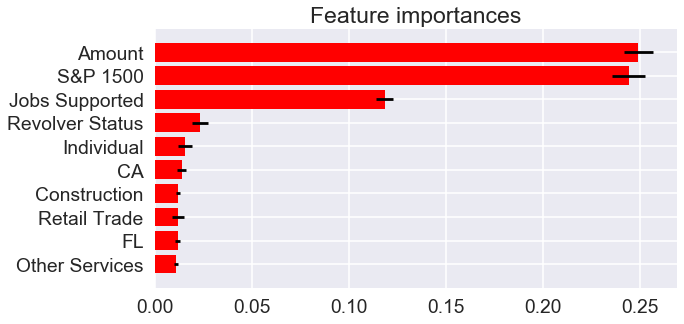

In [117]:
# Plot the feature importances of the forest
importances = rf_l84.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_l84.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
fig = plt.figure(figsize = (10,5))

plt.title("Feature importances")
plt.barh(range(10), importances[indices][0:10][::-1],
       color="r", xerr=std[indices][0:10][::-1], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), ['Amount', 'S&P 1500', 'Jobs Supported', 'Revolver Status',
                      'Individual', 'CA', 'Construction', 'Retail Trade', 'FL', 'Other Services'][::-1])
    
#plt.yticks(range(10), X_train_v5.columns[indices][0:10][::-1])
plt.ylim([-1,10])
plt.tight_layout()


fig.savefig('L84_RF_FImportance.png', dpi = 300)

In [118]:
#try Logistic Regression Classification first with random split and L! reg.

logmodel_l84_v2 = LogisticRegression(penalty = 'l1', class_weight = 'balanced', n_jobs = -1)
logmodel_l84_v2.fit(X_train_v4, y_train_v4)
lm_l84_v2_pred = logmodel_l84_v2.predict(X_test_v4)

In [119]:
print(classification_report(y_test_v4, lm_l84_v2_pred))

             precision    recall  f1-score   support

          0       0.59      0.65      0.62     41870
          1       0.69      0.64      0.66     51770

avg / total       0.65      0.64      0.64     93640



In [120]:
#Build a random control models to compare the RF performance with

pos_prop = np.sum(y_train_v4)/len(y_train_v4)  

expected_pos_in_test = np.round(pos_prop*(len(y_test_v4)))
               
#control 1 predicts everything to be majority class
y_test_con1 = np.ones((len(y_test_v4),1))
                
#control 2 predicts accroding to proportions of positive and negative examples in the training data
zs = np.zeros(len(y_test_v4) - int(expected_pos_in_test)) #zeros
os = np.ones((int(expected_pos_in_test)))
                
zo = np.concatenate((zs, os))
                
y_test_con2 = np.random.permutation(zo)
               

In [121]:
print(classification_report(y_test_v4, y_test_con1))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     41870
          1       0.55      1.00      0.71     51770

avg / total       0.31      0.55      0.39     93640



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [123]:
print(classification_report(y_test_v4, y_test_con2))

             precision    recall  f1-score   support

          0       0.45      0.45      0.45     41870
          1       0.55      0.55      0.55     51770

avg / total       0.51      0.50      0.51     93640



In [124]:
len(X_train_v1.columns)

78

### Random (control) model has much lower precision and recall than RF for loans with duration < 84 months. 